In [1]:
import os
import time
import sys
import argparse
import numpy as np
import onnx
import onnxruntime
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchmetrics import JaccardIndex
from statistics import mean
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from statistics import mean
from tqdm import tqdm

mt_dir = os.getcwd()


batch_size = 1
num_workers = 1
n_runs = 1

def jaccard(input, target):
    l_input = input.astype(bool)
    l_target = target.astype(bool)
    intersection = np.logical_and(l_input, l_target)
    union = np.logical_or(l_input, l_target)
    iou = np.sum(intersection)/np.sum(union)
    return iou

class PackagesInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None,):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename), cv2.IMREAD_UNCHANGED,
        )
        mask = mask.astype(np.float32)
        mask[mask == 0.0] = 0.0
        mask[mask == 255.0] = 1.0
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask, original_size

test_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


test_images_path = os.path.join(mt_dir, "full_dataset/test/images")
test_label_path = os.path.join(mt_dir, "full_dataset/test/labels")
test_images_filenames = [item for item in os.listdir(test_images_path) if item.endswith(".png")]
test_dataset = PackagesInferenceDataset(
    images_filenames=test_images_filenames,
    images_directory=test_images_path, 
    masks_directory=test_label_path, 
    transform=test_transform
)

model_name = "fastscnn_256a0.125t6r2pp0"
model_path = os.path.join(mt_dir, "model_checkpoints/experiments/overall/onnx", model_name)
#load onnx model
onnx_model_path = model_path+"_noinit.onnx"
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)


#inference with onnx
ort_session = onnxruntime.InferenceSession(onnx_model_path)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

#inference over the entire test dataset one image at a time
output_onnx = []
latency_onnx = []
i = 0
for run in tqdm(range(n_runs)):
    for image, msk, (height, width) in test_dataset:
        image = image.unsqueeze(0)
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}
        i+=1
        start = time.time()
        ort_outs = ort_session.run(None, ort_inputs)
        lat = time.time()-start
        latency_onnx.append(lat)
        output_onnx.append([ort_outs, msk])
        #print(f"inference latency on image {i} is {lat}")

print()
print(f"The mean latency in onnx  is: {mean(latency_onnx)}")


ious_onnx = []
preds = []
g_truths = []
for pred, g_truth in output_onnx:
    g_truth = g_truth.numpy()
    outs = np.array(pred)
    outs = outs.squeeze(0) #batch size
    outs = outs.squeeze(0) #channels
    outs = outs.squeeze(0) # onnx output has one extra dimension
    outs = (outs >= 0.5) * 1
    pred = A.resize(
        outs, height=540, width=960, interpolation=cv2.INTER_NEAREST
    )
    preds.append(pred)
    g_truth = A.resize(
        g_truth, height=540, width=960, interpolation=cv2.INTER_NEAREST
    )
    g_truths.append(g_truth)
    ious_onnx.append(jaccard(pred, g_truth))

print()
print("The mean iou of onnx  model is: ", mean(ious_onnx))

/Users/giacomozema/opt/miniconda3/envs/ml/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


The mean latency in onnx  is: 0.0006224314371744791

The mean iou of onnx  model is:  0.961317624997109


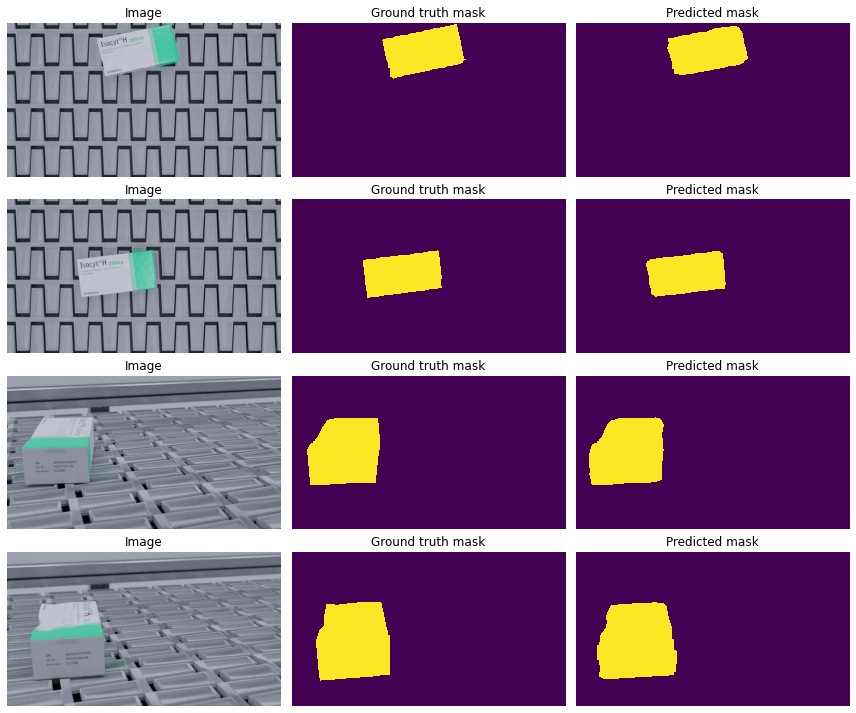

In [2]:
from matplotlib import pyplot as plt

cols = 3 
rows = 4
figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 10))
for i, image_filename in enumerate(test_images_filenames[:rows]):
    image = cv2.imread(os.path.join(test_images_path, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = g_truths[i]
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest")

    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Ground truth mask")

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()

    predicted_mask = preds[i]
    ax[i, 2].imshow(predicted_mask, interpolation="nearest")
    ax[i, 2].set_title("Predicted mask")
    ax[i, 2].set_axis_off()
plt.tight_layout()
plt.show()